In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
aber = np.load("../data/processed/train.npz")

In [7]:
aber["images"].shape

(25000, 28, 28)

In [14]:
for i in range(25000):
    if i % 5000 == 0:
        print(int(i / 5000))

0
1
2
3
4


# Visualizing original MNist first

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
images_iterator = iter(trainloader)

tensor(4)


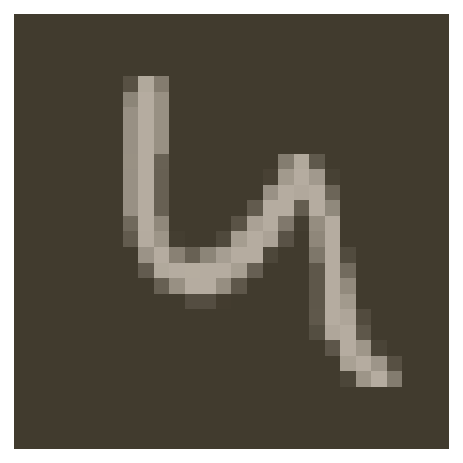

In [4]:
image, label = next(images_iterator)
print(label[0])
helper.imshow(image[0, :]);

In [5]:
print(image.shape)
print(label.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


# Brief exploration of the corrupted data

In [6]:
sample = np.load("../../../data/corruptmnist/train_0.npz")

In [7]:
for key in sample.keys():
    print(key)

images
labels
allow_pickle


In [8]:
print(sample["images"].shape)
print(sample["labels"].shape)

(5000, 28, 28)
(5000,)


In [9]:
final_images = np.empty(shape=(0, 28, 28))
final_labels = np.empty(shape=(0, ))
for file in Path("../../../data/corruptmnist/").iterdir():
    if "train" in str(file):
        final_images = np.append(final_images, np.load(file)["images"], axis=0)
        final_labels = np.append(final_labels, np.load(file)["labels"], axis=0)

# Custom dataloader for the corrupted data

In [10]:
class NPZLoader(Dataset):
    def __init__(self, path, train=True, transform=None):
        super().__init__()
        self.path = path
        self.transform = transform
        if train:
            self.images = np.empty(shape=(0, 28, 28))
            self.labels = np.empty(shape=(0, ))
            for file in Path(path).iterdir():
                if "train" in str(file):
                    self.images = np.append(self.images, np.load(file)["images"], axis=0)
                    self.labels = np.append(self.labels, np.load(file)["labels"], axis=0)
        
        else:
            self.images = np.load(path+"test.npz")["images"]
            self.labels = np.load(path+"test.npz")["labels"]

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, item):
        image = self.images[item]
        label = self.labels[item]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [11]:
path = "../../../data/corruptmnist/"

trainset = NPZLoader(path=path, train=True, transform=transform)
testset = NPZLoader(path=path, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [12]:
images_iterator = iter(testloader)

tensor(3)


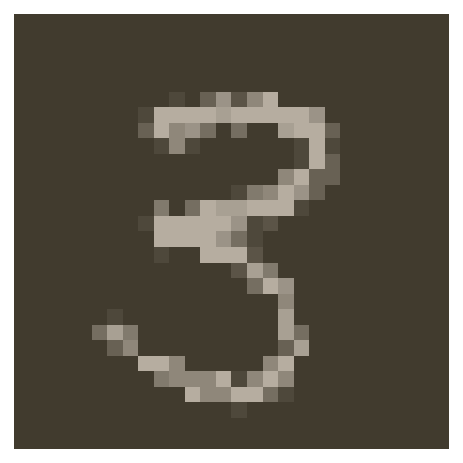

In [13]:
image, label = next(images_iterator)
print(label[0])
helper.imshow(image[0, :]);

In [67]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        x = x.float()

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [68]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
steps = 0
print_every = 50
running_loss = 0
training_losses = []
test_losses = []
test_accuracy = 0

for e in range(epochs):
    # Model in training mode, dropout is on
    model.train()
    for images, labels in trainloader:
        steps += 1
        
        # Flatten images into a 784 long vector
        images.resize_(images.shape[0], 784)
        images = images.type(torch.FloatTensor)
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        labels = labels.type(torch.LongTensor)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if steps % print_every == 0:
            # Model in inference mode, dropout is off
            model.eval()
            
            # Turn off gradients for validation, will speed up inference
            with torch.no_grad():
                accuracy = 0
                test_loss = 0
                for images, labels in testloader:

                    images = images.resize_(images.shape[0], 784)
                    images = images.type(torch.FloatTensor)

                    output = model.forward(images)
                    test_loss += criterion(output, labels).item()

                    ## Calculating the accuracy 
                    # Model's output is log-softmax, take exponential to get the probabilities
                    ps = torch.exp(output)
                    # Class with highest probability is our predicted class, compare with true label
                    equality = (labels.data == ps.max(1)[1])
                    # Accuracy is number of correct predictions divided by all predictions, just take the mean
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    test_accuracy = accuracy/len(testloader)
            
            training_losses.append(running_loss/print_every)
            test_losses.append(test_loss/len(testloader))
            print("Epoch: {}/{} ".format(e+1, epochs),
                    "Training Loss: {:.3f} ".format(running_loss/print_every),
                    "Test Loss: {:.3f} ".format(test_loss/len(testloader)),
                    "Test Accuracy: {:.3f}".format(test_accuracy))
            
            running_loss = 0
            # Make sure dropout and grads are on for training
            model.train()
        
        if test_accuracy >= 0.85:
            break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x128 and 64x10)

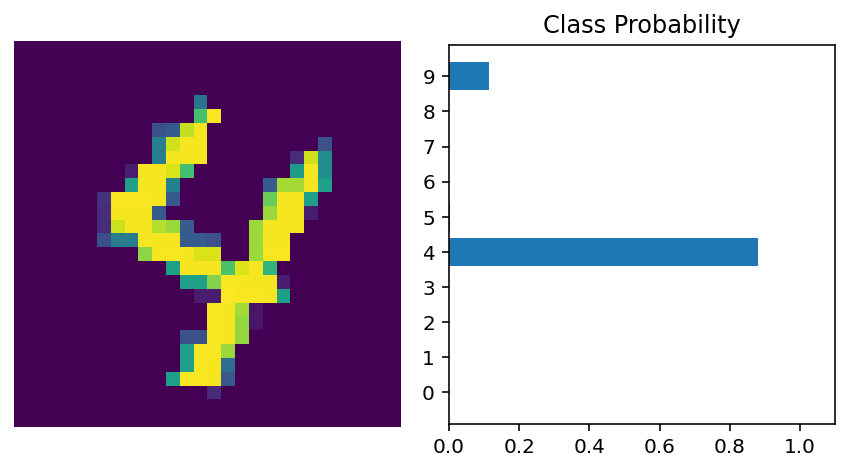

In [59]:
image, label = next(images_iterator)
helper.view_classify(img=image[0, :], ps=torch.exp(model(image[0, :])))

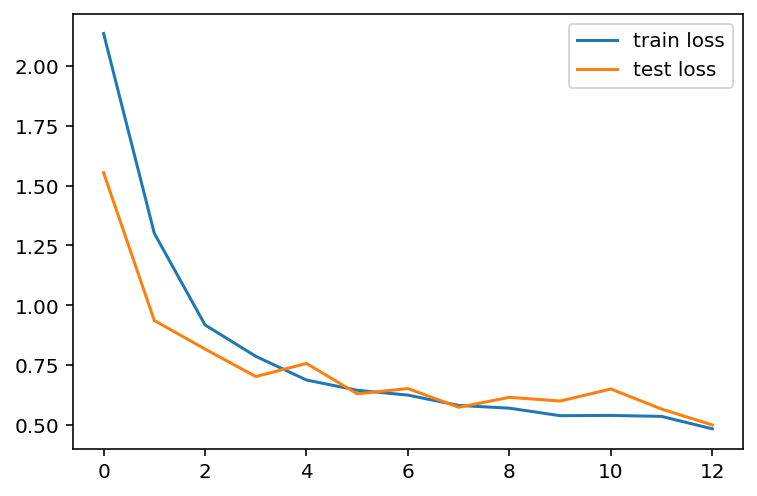

In [60]:
plt.plot(training_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [61]:
print(model.state_dict().keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [62]:
# torch.save(model.state_dict(), "MyAwesomeModelCheckpoint.pth")

In [63]:
images, labels = next(iter(testloader))

In [64]:
accuracy = 0
for images, labels in testloader:
    images = images.resize_(images.shape[0], 784)
    images = images.type(torch.FloatTensor)
    accuracy += (torch.exp(model.forward(images)).max(1)[1] == labels.data).type_as(torch.FloatTensor()).mean()

In [65]:
print(accuracy/len(testloader))

tensor(0.7660)
